In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings(action='ignore')

from utils import preprocessing as my_prep
from utils import regression as my_reg
from utils import evaluate as my_eval

# Data load

In [2]:
data_new = pd.read_csv("./data/seoul_preprocessed2_y_nextquarter.csv")
data_new.shape

(173745, 30)

### 분기별로 분할

In [3]:
quarters = ['2017_1', '2017_2', '2017_3', '2017_4', '2018_1', '2018_2', '2018_3', '2018_4', '2019_1', '2019_2', '2019_3']
datas = {}
for q in quarters:
    year, quarter = map(int, q.split("_"))
    
    bool_year = data_new.기준_년_코드==year
    bool_quarter = data_new.기준_분기_코드==quarter
    datas[q] = data_new[bool_year & bool_quarter] 
    
for key in datas.keys():
    print(key, datas[key].shape)

2017_1 (15795, 30)
2017_2 (15795, 30)
2017_3 (15795, 30)
2017_4 (15795, 30)
2018_1 (15795, 30)
2018_2 (15795, 30)
2018_3 (15795, 30)
2018_4 (15795, 30)
2019_1 (15795, 30)
2019_2 (15795, 30)
2019_3 (15795, 30)


# Split train, validate, test

In [4]:
trainfiles = ['2017_1', '2017_2', '2017_3', '2017_4', '2018_1', '2018_2', '2018_3']
validatefiles = []
testfiles = ['2018_4', '2019_1', '2019_2', '2019_3']  # 2019_1, 2019_2, 2019_3, 2019_4 맞추기

train, validate, test = my_prep.split_train_val_test_by_file(datas, trainfiles, validatefiles, testfiles, category='편의점')
print(train.shape, validate.shape, test.shape)

[train] 2017_1 : (1147, 30), accumulate : (1147, 30)
[train] 2017_2 : (1147, 30), accumulate : (2294, 30)
[train] 2017_3 : (1147, 30), accumulate : (3441, 30)
[train] 2017_4 : (1147, 30), accumulate : (4588, 30)
[train] 2018_1 : (1147, 30), accumulate : (5735, 30)
[train] 2018_2 : (1147, 30), accumulate : (6882, 30)
[train] 2018_3 : (1147, 30), accumulate : (8029, 30)
[test] 2018_4 : (1147, 30), accumulate : (1147, 30)
[test] 2019_1 : (1147, 30), accumulate : (2294, 30)
[test] 2019_2 : (1147, 30), accumulate : (3441, 30)
[test] 2019_3 : (1147, 30), accumulate : (4588, 30)
(8029, 30) (0, 0) (4588, 30)


### split x, y

In [5]:
#x_header = [x for x in train.columns if '연령대' in x and x.find('연령대')==0]
x_header = [x for x in train.columns if '남성연령대' in x or '여성연령대' in x]
y_header = ['다음분기_매출_금액']
print(x_header, y_header)

['남성연령대_10_유동인_수', '남성연령대_20_유동인_수', '남성연령대_30_유동인_수', '남성연령대_40_유동인_수', '남성연령대_50_유동인_수', '남성연령대_60_유동인_수', '여성연령대_10_유동인_수', '여성연령대_20_유동인_수', '여성연령대_30_유동인_수', '여성연령대_40_유동인_수', '여성연령대_50_유동인_수', '여성연령대_60_유동인_수'] ['다음분기_매출_금액']


In [6]:
x_train, y_train = my_prep.split_xy(train, x_header, y_header)
# x_validate, y_validate = my_prep.split_xy(validate, x_header, y_header)
x_test, y_test = my_prep.split_xy(test, x_header, y_header)

print('train', x_train.shape, y_train.shape)
# print('validate', x_validate, y_validate)
print('test', x_test.shape, y_test.shape)

train (8029, 12) (8029, 1)
test (4588, 12) (4588, 1)


### Option(random split)

In [7]:
x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))
print('train', x_train.shape, y_train.shape)

train (12617, 12) (12617, 1)


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (8831, 12) (8831, 1)
test (3786, 12) (3786, 1)


# Normalize, PCA

### Normalize

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scale = scaler.transform(x_train)
x_test_scale = scaler.transform(x_test)

scaler_y = StandardScaler().fit(y_train)
y_train_scale = scaler_y.transform(y_train)
y_test_scale = scaler_y.transform(y_test)

print('train', x_train_scale.shape, y_train_scale.shape)
print('test', x_test_scale.shape, y_test_scale.shape)

train (8831, 12) (8831, 1)
test (3786, 12) (3786, 1)


### PCA

In [10]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train_scale)
x_train_pca = pca.transform(x_train_scale)
x_test_pca = pca.transform(x_test_scale)
print(x_train_pca.shape, x_test_pca.shape)

(8831, 12) (3786, 12)


In [11]:
pca.explained_variance_ratio_.round(2)

array([0.79, 0.11, 0.07, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [12]:
top_n = 2
x_train_pca_selected = x_train_pca[:, :top_n]
x_test_pca_selected = x_test_pca[:, :top_n]
print(x_train_pca_selected.shape, x_test_pca_selected.shape)

(8831, 2) (3786, 2)


### Correlation coefficient

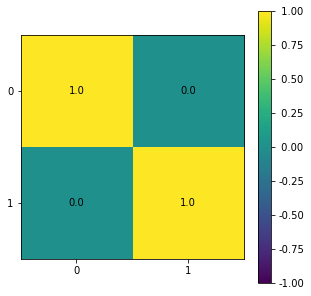

In [13]:
my_eval.visualize_CorrelCoeff_heatmap(x_train_pca_selected, np.arange(top_n), figsize=(5, 5))

# Training

In [14]:
x_train_final, y_train_final = x_train_pca_selected, y_train_scale
x_test_final, y_test_final = x_test_pca_selected, y_test_scale

In [15]:
model_LR = my_reg.get_model_LinearRegression(x_train_final, y_train_final)
model_Elastic = my_reg.get_model_ElasticNet(x_train_final, y_train_final)
model_SVR = my_reg.get_model_SVR(x_train_final, y_train_final)

# hidden_layers = [512, 256, 4]
# model_MLPRegression = my_reg.get_model_MLPRegression(
#     x_train_scale, y_train_scale, 
#     hidden_layers=hidden_layers,
#     max_iter=5000,
#     alpha=0.0001,
#     random_state=42
# )

In [16]:
model_LR.coef_

array([[0.1652752 , 0.36373972]])

### Keras (Tensorflow 2.2.0)

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.2.0


In [18]:
def build_model(input_shape):
    model = keras.Sequential([
    layers.Dense(12, activation='relu', input_shape=input_shape),
    layers.Dense(6, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.00001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [ ]:
model_MLPRegression = build_model(input_shape=[x_train_final.shape[1]])
model_MLPRegression.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

epo = 0
val_mse = 0
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        global epo
        global val_mse
        epo = epoch
        val_mse = logs['val_mse']
        
        if epoch % 50 == 0:
            print('.', end='')
            #print(logs)
        
# # epoche 끝날때마다 모델 저장
# ModelCheck = ModelCheckpoint(os.path.join('./log', 'MLP_PCA'+'-{epoch:04d}-{val_mse:.4f}.hdf5'), monitor='val_mse', verbose=0, 
#                          save_best_only=True, save_weights_only=False, mode='auto', period=1)

# metric의 상승이 멈출때마다 learning rate 낮춤
ReduceLR = ReduceLROnPlateau(monitor='val_mse', factor=0.2, mode='auto',
                          patience=5, min_lr=1e-6, verbose=1)

EarlyStop = EarlyStopping(monitor='val_mse', mode='auto', patience=10, restore_best_weights=True)

EPOCHS = 5000

history = model_MLPRegression.fit(
    x_train_final, y_train_final, 
    batch_size=32,epochs=EPOCHS, verbose=0,
    validation_data = (x_test_final, y_test_final),
    callbacks=[PrintDot(), ReduceLR, EarlyStop])

model_MLPRegression.save('./log/2MLP_PCA-epoch:%04d-val_mse:%.4f}.hdf5' %(epo, val_mse))

In [ ]:
model_MLPRegression(x_test_final[0, :].reshape(1, 2))

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,np.max(hist['val_mae'])+2])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,np.max(hist['val_mse'])+2])
    plt.legend()
    plt.show()

plot_history(history)

# Evaluate

### Linear Regression

In [ ]:
my_eval.eval_regression(y_test_final, model_LR.predict(x_test_final), model_name='Linear Regression')

### ElasticNet

In [ ]:
my_eval.eval_regression(y_test_final, model_Elastic.predict(x_test_final), model_name='ElasticNet')

### SVR

In [ ]:
my_eval.eval_regression(y_test_final, model_SVR.predict(x_test_final), model_name='SVM Regression')

# MLP Regressoin

In [ ]:
my_eval.eval_regression(y_test_final, model_MLPRegression.predict(x_test_final), model_name='MLP Regression')

# 오차 계산

In [ ]:
def evaluate_error(y_gt, y_pred, title=''):
    li_error = []
    for i in zip(y_gt, y_pred):
        error = (abs(i[0]-i[1])/i[0])
        li_error.append(error)

    print(sum(li_error), y_pred.shape[0])
    print('평균 오차 %.lf%%' %(np.mean(li_error)))
    print('최대 오차 %.lf%%' %(np.max(li_error)))
    print('최소 오차 %.lf%%' %(np.min(li_error)))

    #li_error.sort(reverse=True)
    #print('Top 10 오차 %s' %(li_error[:10]))
    plt.plot(li_error)
    plt.title(title)

In [ ]:
#### normed
y_pred_scale_MLP = model_MLPRegression.predict(x_test_final)
y_pred_MLP = scaler_y.inverse_transform(y_pred_scale_MLP)

#### non-normed
#y_pred_MLP = model_MLPRegression.predict(x_test_final)

evaluate_error(y_test[:, 0], y_pred_MLP, title='MLP error')

In [ ]:
y_pred_scale_LR = model_LR.predict(x_test_final)
y_pred_LR = scaler_y.inverse_transform(y_pred_scale_LR)

evaluate_error(y_test[:, 0], y_pred_LR, title="LR error")

In [ ]:
y_pred_scale_Elastic = model_Elastic.predict(x_test_final)
y_pred_Elastic = scaler_y.inverse_transform(y_pred_scale_Elastic)

evaluate_error(y_test[:, 0], y_pred_Elastic, title='Elastic error')

# Conclusion

##### 정답 값이 너무 비슷? 몇명만 너무 큼? 
##### 큰 의미가 없나?

In [ ]:
plt.plot(y_test)

In [ ]:
print('MLP', int(scaler_y.inverse_transform([-0.02651767])))
print('LR', int(scaler_y.inverse_transform([-0.06412931])))
#print('SVR', int(scaler_y.inverse_transform([-0.02651767])))
print('Elastic', int(scaler_y.inverse_transform([4.09963574e-10])))    #
print('ground truth', y_test[0, 0])

# TODO

1) 전처리  
- 가중치부여    

2) 차원축소  
 - wrapper, PCA    

3) 증분  
 - 회귀 증분?    

4) 모델 
 - LGBM, MLP monitoring  

5) 학습/검증 분할
 - random
 - k-fold(train,validate)/test
 - sequence  
 
6) 분석, 결론
 - MSE, R2
 - 오차
 - 시각화 (지도?)

버릴건 버려야